In [2]:
import sys
sys.path.append('../code')
from resnet import *
from funcs import *
from cifar_very_tiny import *
from cifar_dataset import *    
import torch as t 
import numpy as np
from numpy import polyfit
from numpy import polyval
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from scipy.interpolate import interp1d
from PIL import Image
%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

# Dataset loading

In [2]:
# добавил в загрузку валидационную выборку
# обрати внимание, maxsize --- это размер совокпного обучения и валидации
# поэтому размер обучающей выборки совпадает с тем, что было до этого

train_loader_no_augumentation, test_loader = cifar10_loader(batch_size=128, split_train_val=False,
                                                                             maxsize=128*100, use_aug=False)


Files already downloaded and verified
Files already downloaded and verified


# Experiments

In [3]:
epoch_num = 50
# epoch_num = 50

run_num = 10 # количество запусков эксперимента

# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '33'

validate_every_epoch = 5 

# train_splines_every_epoch = 5 # каждые 5 эпох отслеживать траекторию гиперпараметров
# train_splines_every_epoch = 2
# train_splines_every_epoch = 3
train_splines_every_epoch = 10

# размер мини-эпохи в батчах, за которую у нас производится либо обучение спайлов, либо их использование
mini_epoch_size = 10

start_beta = 0.5
start_temp  = 1.0

### without distillation

In [ ]:
# запуск без дистилляции
filename='nodistil'
cifar_base(experiment_version, run_num, epoch_num, start_beta, start_temp, filename, 
           tr_load=train_loader_no_augumentation, t_load=test_loader, 
           validate_every_epoch=validate_every_epoch, lr0=1.0)

current loss:1.7794675827026367:   4%|▍         | 4/100 [00:00<00:02, 39.73it/s]

{'epoch': 0, 'test loss': 1.7193422317504883, 'accuracy': 0.34869998693466187}


current loss:1.2417484521865845:   4%|▍         | 4/100 [00:00<00:02, 39.47it/s]

{'epoch': 4, 'test loss': 1.552864670753479, 'accuracy': 0.44689998030662537}


current loss:1.1055296659469604:  81%|████████  | 81/100 [00:02<00:00, 38.92it/s]

### with distillation and start_lambda1, start_temp

In [ ]:
# Запуск --- с CNN-дистилляцией
filename='distil'
cifar_base(experiment_version, run_num, epoch_num, start_beta, start_temp, filename, 
           tr_load=train_loader_no_augumentation, t_load=test_loader, 
           validate_every_epoch=validate_every_epoch, mode='distil', lr0=1.0, logits='../code/logits_resnet.npy')

### with random metaparameter values

In [ ]:
# Запуск --- со случаными значениями гиперпараметров
filename='random'
cifar_base(experiment_version, run_num, epoch_num, start_beta, start_temp, filename, 
           tr_load=train_loader_no_augumentation, t_load=test_loader, 
           validate_every_epoch=validate_every_epoch, mode='random', lr0=1.0, logits='../code/logits_resnet.npy')

### with distillation and 2 coefficients

In [4]:
train_loader_no_augumentation, valid_loader, test_loader = cifar10_loader(batch_size=128, split_train_val=True,
                                                                             maxsize=128*100, use_aug=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-lambda
filename='opt'
cifar_with_validation_set(experiment_version, run_num, epoch_num, filename,
                          tr_s_epoch=train_splines_every_epoch,
                          m_e=mini_epoch_size,
                          tr_load=train_loader_no_augumentation, 
                          t_load=test_loader, 
                          val_load=valid_loader,   
                          validate_every_epoch=validate_every_epoch, 
                          mode='opt', lr0=1.0, lr=.25, logits='../code/logits_resnet.npy')

### distillation with linear models (par: epoch_size)

In [ ]:
# TODO здесь нужны эксперименты с mini_epoch_size и train_splines_every_epoch
for e in [10, 100, 1000, 2000]:
    filename='splines_2_{}'.format(e)
    cifar_with_validation_set(experiment_version, run_num, epoch_num, filename,
                          tr_s_epoch=2,
                          m_e=e,
                          tr_load=train_loader_no_augumentation, 
                          t_load=test_loader, 
                          val_load=valid_loader, 
                          validate_every_epoch=validate_every_epoch, 
                          mode='splines', lr0=1.0, lr=.25, logits='../code/logits_resnet.npy')

current loss:1.5365206003189087:  74%|███████▍  | 67/90 [00:03<00:01, 18.11it/s]

### distillation with linear models (par: train_splines_every_epoch)

In [ ]:
# TODO здесь нужны эксперименты с mini_epoch_size и train_splines_every_epoch
for tse in [2,3,5,10]:
    filename='splines_{}_10'.format(tse)
    cifar_with_validation_set(experiment_version, run_num, epoch_num, filename,
                          tr_s_epoch=tse,
                          m_e=10,
                          tr_load=train_loader_no_augumentation, 
                          t_load=test_loader, 
                          val_load=valid_loader, 
                          validate_every_epoch=validate_every_epoch, 
                          mode='splines', lr0=1.0, lr=.25, logits='../code/logits_resnet.npy')

### with linear models

In [ ]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-lambda (с линейными моделями)
filename='splines'
cifar_with_validation_set(experiment_version, run_num, epoch_num, filename,                          
                          m_e = mini_epoch_size,
                           tr_s_epoch=train_splines_every_epoch,
                          tr_load=train_loader_no_augumentation,
                          t_load=test_loader, 
                          val_load=valid_loader, 
                          validate_every_epoch=validate_every_epoch, 
                          mode='splines', lr0=1.0, lr=0.25, logits='../code/logits_resnet.npy')

### with HyperOpt

In [ ]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-lambda (с линейными моделями)
filename='hyperopt'
cifar_with_hyperopt(experiment_version, run_num, epoch_num, filename,
                          tr_s_epoch=train_splines_every_epoch,
                          m_e=mini_epoch_size,
                          tr_load=train_loader_no_augumentation, 
                          t_load=test_loader, 
                          val_load=valid_loader, 
                          validate_every_epoch=validate_every_epoch, 
                          trial_num=5, lr0=1.0, logits='../code/logits_resnet.npy')

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]
../code/funcs.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  g = F.log_softmax(out/temp)



{'epoch': 0, 'test loss': 1.9586377143859863, 'val loss': 1.961168646812439, 'accuracy': 0.2985999882221222, 'temp': 0.6608721613883972, 'lambda1': 0.9040369391441345, 'val acc': 0.28125}
  0%|          | 0/5 [00:08<?, ?trial/s, best loss=?]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]


{'epoch': 4, 'test loss': 1.4138766527175903, 'val loss': 1.4336329698562622, 'accuracy': 0.5001000165939331, 'temp': 0.6608721613883972, 'lambda1': 0.9040369391441345, 'val acc': 0.4921875}
  0%|          | 0/5 [00:27<?, ?trial/s, best loss=?]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]


In [ ]:
cifar_with_validation_set(None, 1, epoch_num, filename, train_splines_every_epoch, mini_epoch_size, 
                          train_loader_no_augumentation, test_loader, valid_loader, 
                          validate_every_epoch, lambdas = [0.64, 0.17],  mode='no-opt', lr0=1.0, logits='../code/logits_resnet.npy')

# Results

In [15]:
np.max([d['results'][-1]['accuracy'] for d in data_ho])

0.5819999575614929

In [4]:
data_b = open_data_json("../log/exp33_nodistil.jsonl")
data_d = open_data_json("../log/exp33_distil.jsonl")
data_dr = open_data_json("../log/exp33_random.jsonl")
data_h = open_data_json("../log/exp33_opt.jsonl")
data_s = open_data_json("../log/exp33_splines.jsonl")
data_ho = open_data_json("../log/exp33_hyperopt.jsonl")

In [19]:
from matplotlib import pylab as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 36

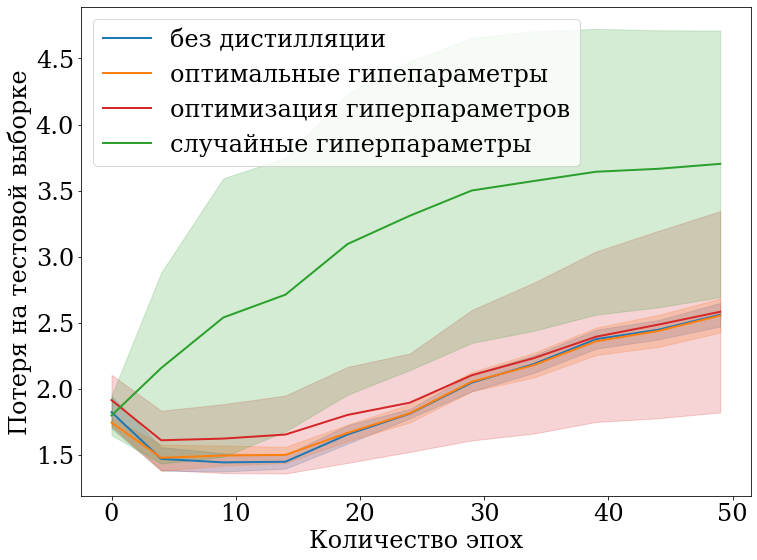

In [6]:
plot_data_params(data_b, 'test loss', 'без дистилляции', 'tab:blue', '')
plot_data_params(data_d, 'test loss', 'оптимальные гипепараметры', 'tab:orange', '')
plot_data_params(data_dr, 'test loss', 'оптимизация гиперпараметров', 'tab:red', '')
plot_data_params(data_h, 'test loss', 'случайные гиперпараметры', 'tab:green', '')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')

plt.legend()
plt.savefig('../figs/loss_full.pdf')

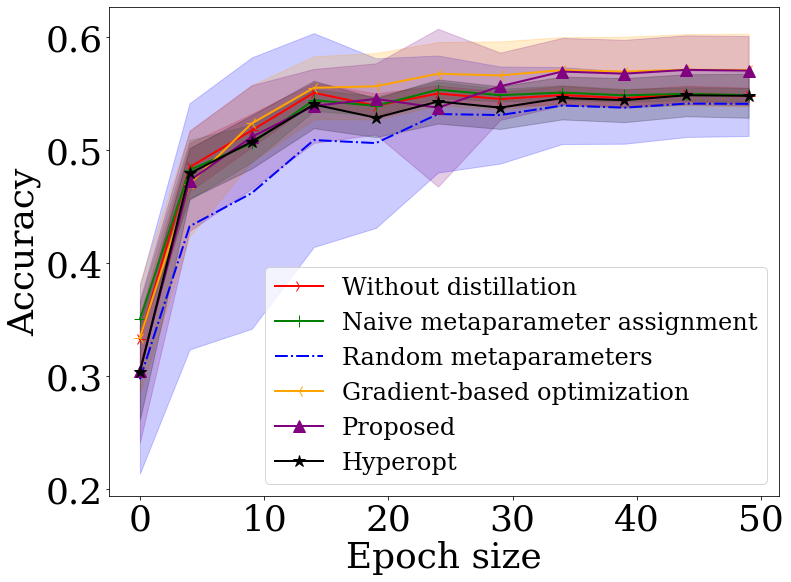

In [20]:
plot_data_params(data_b, 'accuracy', 'Without distillation', 'red', '4')
plot_data_params(data_d, 'accuracy', 'Naive metaparameter assignment', 'green', '+')
plot_data_params(data_dr, 'accuracy', 'Random metaparameters', 'blue', '.')
plot_data_params(data_h, 'accuracy', 'Gradient-based optimization', 'orange', '3')
plot_data_params(data_s, 'accuracy', 'Proposed', 'purple', '^')
plot_data_params(data_ho, 'accuracy', 'Hyperopt', 'black', '*')
plt.legend()
plt.xlabel('Epoch size')
plt.ylabel('Accuracy')
plt.savefig('../figs/mini_cifar_accuracy.pdf')

In [11]:
data_h = open_data_json("../log/exp31_opt.jsonl")

In [12]:
def plot_data_params2(data, s, label, color, sign):
    e = np.array([data[0]['results'][i]['epoch'] for i in range(len(data[0]['results']))])
    par = np.array([subdata['results'][i][s] for i in range(len(data[0]['results'])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, par, '-'+sign, color=color, label=label)
    

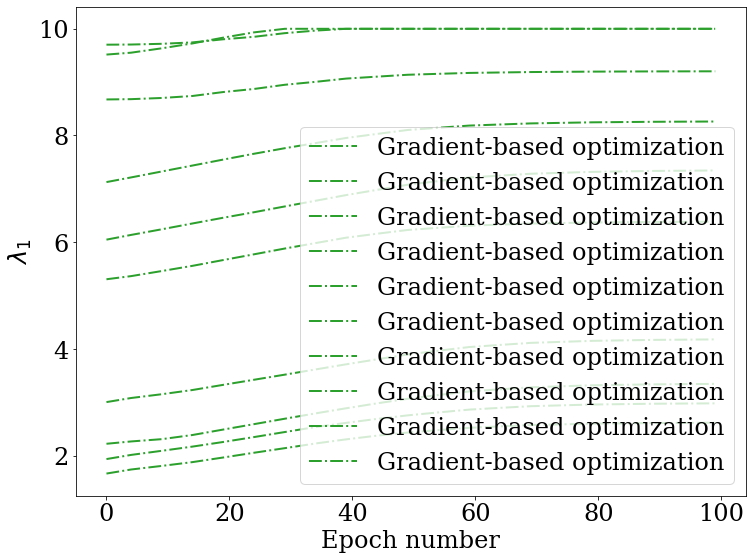

In [13]:
plot_data_params2(data_h, 'temp', 'Gradient-based optimization', 'tab:green', '.')



plt.xlabel('Epoch number')
plt.ylabel('$\lambda_1$')
plt.legend()
plt.savefig('../figs/mini_cifar_lambda1.pdf')


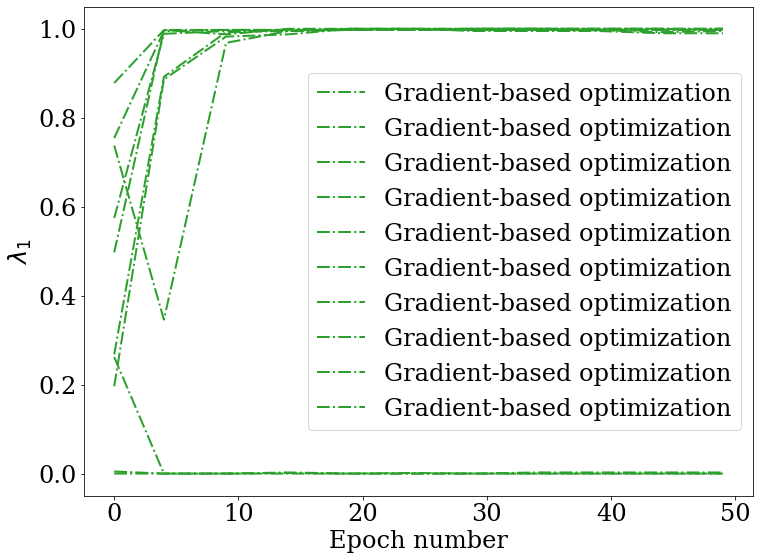

In [24]:
plot_data_params2(data_h, 'lambda1', 'Gradient-based optimization', 'tab:green', '.')



plt.xlabel('Epoch number')
plt.ylabel('$\lambda_1$')
plt.legend()
plt.savefig('../figs/mini_cifar_lambda1.pdf')


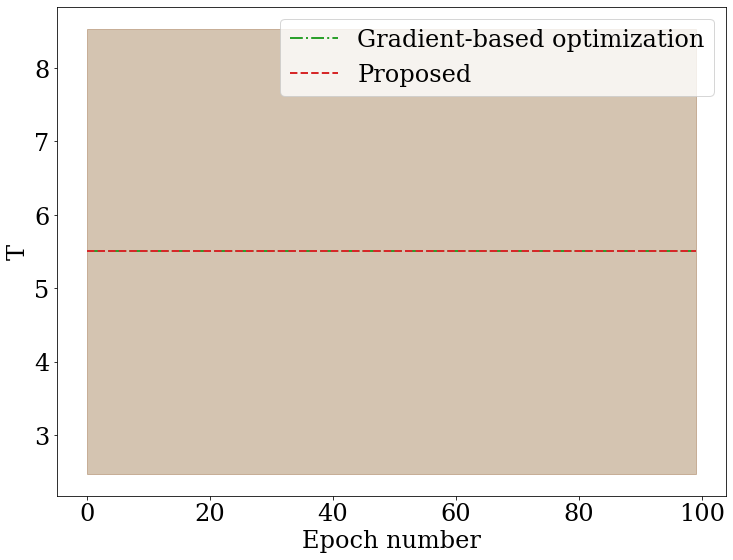

In [27]:
plot_data_params(data_h, 'temp', 'Gradient-based optimization', 'tab:green', '.')
plot_data_params(data_s, 'temp', 'Proposed', 'tab:red', '-')


plt.xlabel('Epoch number')
plt.ylabel('T')
plt.legend()
plt.savefig('../figs/mini_cifar_temp.pdf')


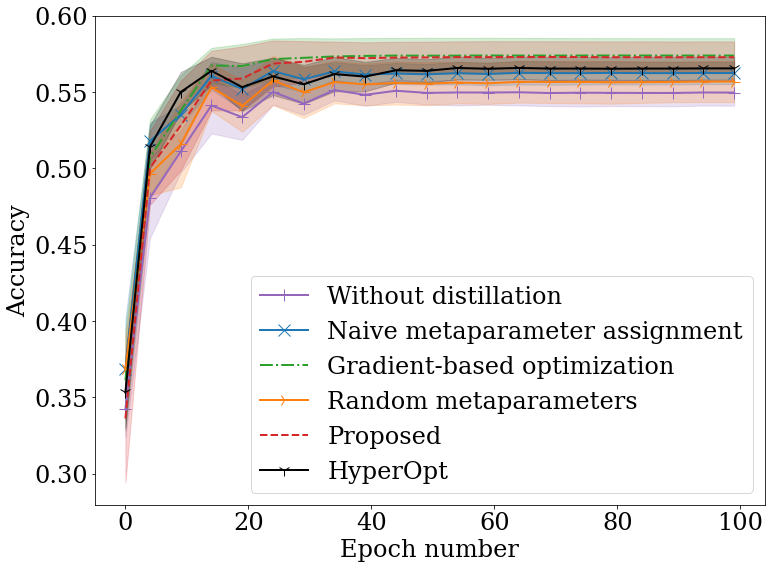

In [22]:
plot_data_params(data_b, 'accuracy', 'Without distillation', 'tab:purple', '+')
plot_data_params(data_d, 'accuracy', 'Naive metaparameter assignment', 'tab:blue', 'x')
plot_data_params(data_h, 'accuracy', 'Gradient-based optimization', 'tab:green', '.')
plot_data_params(data_dr, 'accuracy', 'Random metaparameters', 'tab:orange', '4')
plot_data_params(data_s, 'accuracy', 'Proposed', 'tab:red', '-')
plot_data_params(data_ho, 'accuracy', 'HyperOpt', 'k', '1')

plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figs/mini_cifar_accuracy.pdf')


In [41]:
data_h

[{'epoch': 99,
  'test loss': 2.390197515487671,
  'accuracy': 0.5590000152587891,
  'temp': 9.51207160949707,
  'lambda1': 0.3745401203632355},
 {'epoch': 99,
  'test loss': 1.7725995779037476,
  'accuracy': 0.5723999738693237,
  'temp': 6.026719093322754,
  'lambda1': 0.7319939136505127},
 {'epoch': 99,
  'test loss': 2.821131706237793,
  'accuracy': 0.5598999857902527,
  'temp': 1.644345760345459,
  'lambda1': 0.15601864457130432},
 {'epoch': 99,
  'test loss': 2.685500144958496,
  'accuracy': 0.5309999585151672,
  'temp': 8.67514419555664,
  'lambda1': 0.058083612471818924},
 {'epoch': 99,
  'test loss': 2.048764705657959,
  'accuracy': 0.5625999569892883,
  'temp': 7.109918594360352,
  'lambda1': 0.6011149883270264},
 {'epoch': 99,
  'test loss': 2.7388064861297607,
  'accuracy': 0.5476999878883362,
  'temp': 9.702107429504395,
  'lambda1': 0.02058449387550354},
 {'epoch': 99,
  'test loss': 1.6062381267547607,
  'accuracy': 0.5812999606132507,
  'temp': 2.2021572589874268,
  'lam

In [68]:
([k['results'][-1]['accuracy'] for k in data_d])

[0.5661999583244324,
 0.5539999604225159,
 0.56659996509552,
 0.5482000112533569,
 0.5670999884605408,
 0.5561000108718872,
 0.566100001335144,
 0.5601999759674072,
 0.5730999708175659,
 0.5670999884605408]

In [41]:
import torch
q = torch.tensor([[0.9, 0.05, 0.05]])
p = torch.tensor([[1.0, 0.0, 0.0]])
torch.nn.NLLLoss()(t.log(q),torch.tensor([0])), torch.nn.KLDivLoss()(t.log(q), p)

(tensor(0.1054), tensor(0.0351))

In [85]:
for k in zip([k['results'][-1] for k in data_h], [k['results'][-1] for k in data_dr]):
    print (k[0]['accuracy'], k[1]['accuracy'])

0.5734999775886536 0.5590000152587891
0.5526999831199646 0.5723999738693237
0.580299973487854 0.5598999857902527
0.574400007724762 0.5309999585151672
0.5554999709129333 0.5625999569892883
0.588699996471405 0.5476999878883362
0.5194000005722046 0.5812999606132507
0.5880999565124512 0.546999990940094
0.578000009059906 0.5479999780654907
0.5884000062942505 0.5604999661445618


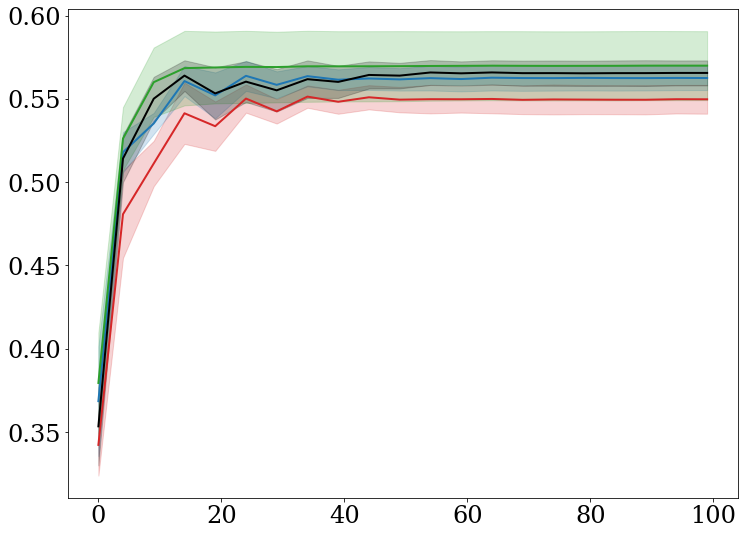

In [83]:
plot_data_params(data_b, 'accuracy', 'без дистилляции', 'tab:red', '')
plot_data_params(data_d, 'accuracy', 'оптимальные гипепараметры', 'tab:blue', '')
plot_data_params(data_h, 'accuracy', 'оптимизация гиперпараметров', 'tab:green', '')
#plot_data_params(data_dr, 'accuracy', 'случайные гиперпараметры', 'tab:orange', '')
#plot_data_params(data_s, 'accuracy', 'прогнозирование гиперпараметров', 'tab:red', '')
plot_data_params(data_ho, 'accuracy', 'HyperOpt', 'k', '')

#plt.xlabel('Количество эпох')
#plt.ylabel('Точность классификации')
#plt.legend()
#plt.ylim((0.50, 0.60))

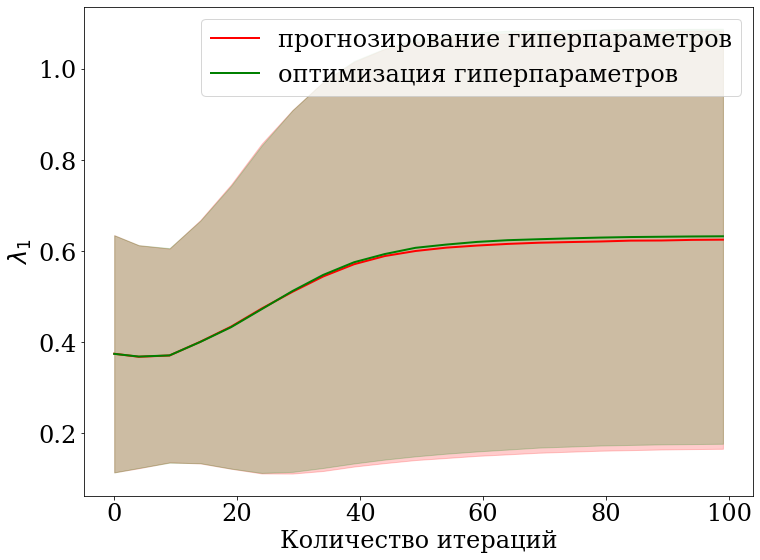

In [9]:
plot_data_params(data_s, 'lambda1', 'прогнозирование гиперпараметров', 'red', '')

plt.xlabel('Количество итераций')
plt.ylabel(r'$\lambda_1$')
# plt.title(r'График зависимости значения $\lambda_1$ от номера итерации')
plt.legend()
plt.savefig('../figs/lambda1_iter_full.pdf')
plt.show()

In [11]:
plot_data_params(data_s, 'lambda2', 'прогнозирование гиперпараметров', 'red', '')
# plot_data_params(data_dr, 'lambda2', 'случайные гиперпараметров', 'blue', '')
plot_data_params(data_h, 'lambda2', 'оптимизация гиперпараметров', 'green', '')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\lambda_2$')
# plt.title(r'График зависимости значения $\lambda_2$ от номера итерации')
plt.legend()
plt.savefig('../figs/lambda2_iter_full.pdf')
plt.show()

KeyError: 'lambda2'

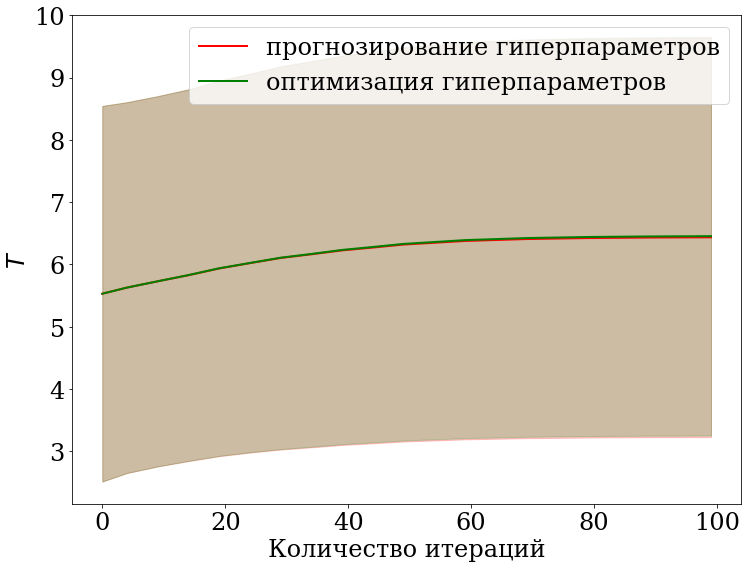

In [12]:
plot_data_params(data_s, 'temp', 'прогнозирование гиперпараметров', 'red', '')
#plot_data_params(data_dr, 'temp', 'случайные гиперпараметров', 'blue', '')
plot_data_params(data_h, 'temp', 'оптимизация гиперпараметров', 'green', '')
plt.xlabel('Количество итераций')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('../figs/temp_iter_full.pdf')
plt.show()

In [28]:
data_2 = open_data_json("../log/exp33_splines_2_10.jsonl")
data_3 = open_data_json("../log/exp33_splines_3_10.jsonl")
data_5 = open_data_json("../log/exp33_splines_5_10.jsonl")
data_10 = open_data_json("../log/exp33_splines_10_10.jsonl")

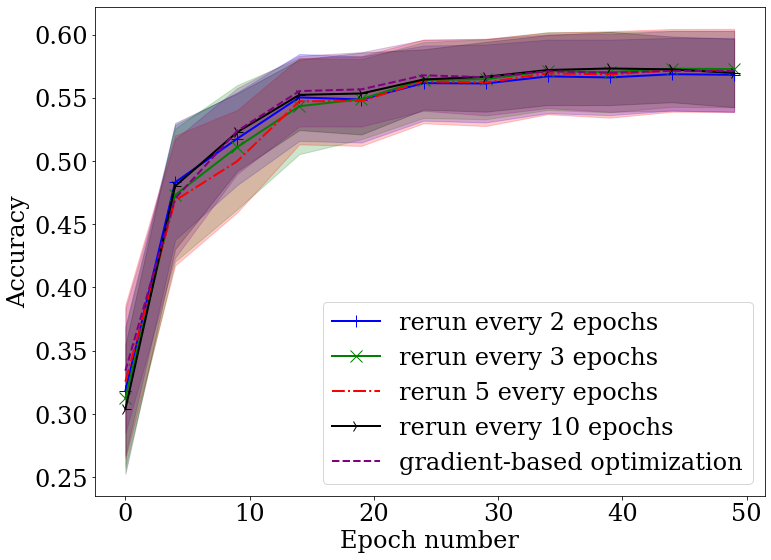

In [29]:
#plot_data_params(data_s, 'accuracy', 'прогнозирование гиперпараметров', 'purple', '')
plot_data_params(data_2,  'accuracy',  'rerun every 2 epochs', 'blue', '+')
plot_data_params(data_3,  'accuracy',  'rerun every 3 epochs', 'green', 'x')
plot_data_params(data_5,  'accuracy', 'rerun 5 every epochs', 'red', '.')
plot_data_params(data_10,   'accuracy',  'rerun every 10 epochs', 'black', '4')
plot_data_params(data_h,   'accuracy',  'gradient-based optimization', 'purple', '-')

#plot_data_params(data_b, 'accuracy', 'without distillation', 'black', '+')
#plot_data_params(data_h, 'accuracy', 'metaparamter optimization', 'green', 'x')
#plot_data_params(data_dr, 'accuracy', 'random metaparameters', 'blue', '.')
#plot_data_params(data_s, 'accuracy', 'metaparameter prediction', 'red', '4')


plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figs/mini_cifar_mini_epochs.pdf')

In [3]:
data_10 = open_data_json("../log/exp33_splines_2_10.jsonl")
data_100 = open_data_json("../log/exp33_splines_2_100.jsonl")
data_1000 = open_data_json("../log/exp33_splines_2_1000.jsonl")
data_2000 = open_data_json("../log/exp33_splines_2_2000.jsonl")

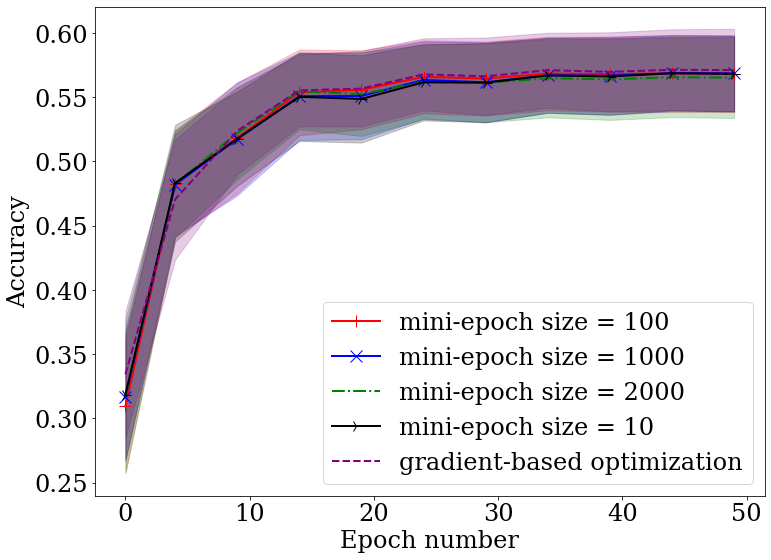

In [31]:
#plot_data_params(data_s[:D], 'accuracy', 'прогнозирование гиперпараметров', 'red', '')
plot_data_params(data_100,  'accuracy', 'mini-epoch size = 100', 'red', '+')
plot_data_params(data_1000,  'accuracy',  'mini-epoch size = 1000', 'blue', 'x')
plot_data_params(data_2000,  'accuracy',  'mini-epoch size = 2000', 'green', '.')
plot_data_params(data_10,   'accuracy',  'mini-epoch size = 10', 'black', '4')
plot_data_params(data_h,   'accuracy',  'gradient-based optimization', 'purple', '-')


plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figs/mini_cifar_mini_epochs2.pdf')

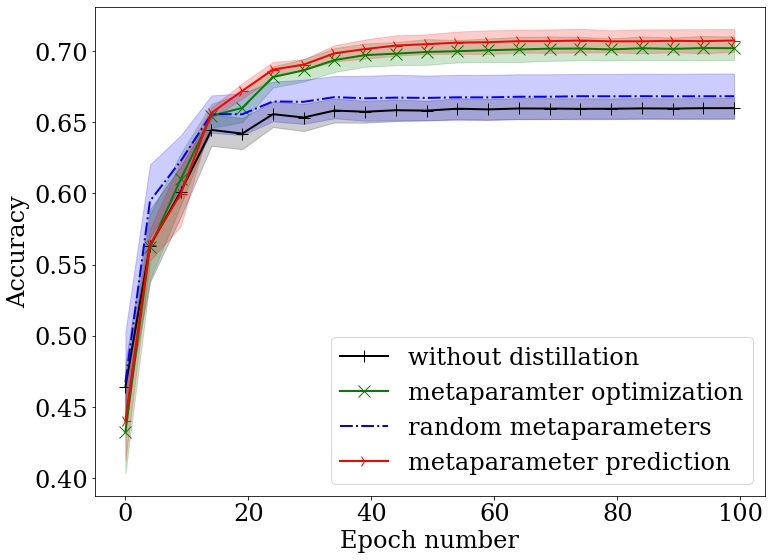

In [13]:
plot_data_params(data_b, 'accuracy', 'without distillation', 'black', '+')
plot_data_params(data_h, 'accuracy', 'metaparamter optimization', 'green', 'x')
plot_data_params(data_dr, 'accuracy', 'random metaparameters', 'blue', '.')
plot_data_params(data_s, 'accuracy', 'metaparameter prediction', 'red', '4')

plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figs/acc_'+experiment_version+'_eng_full.pdf')

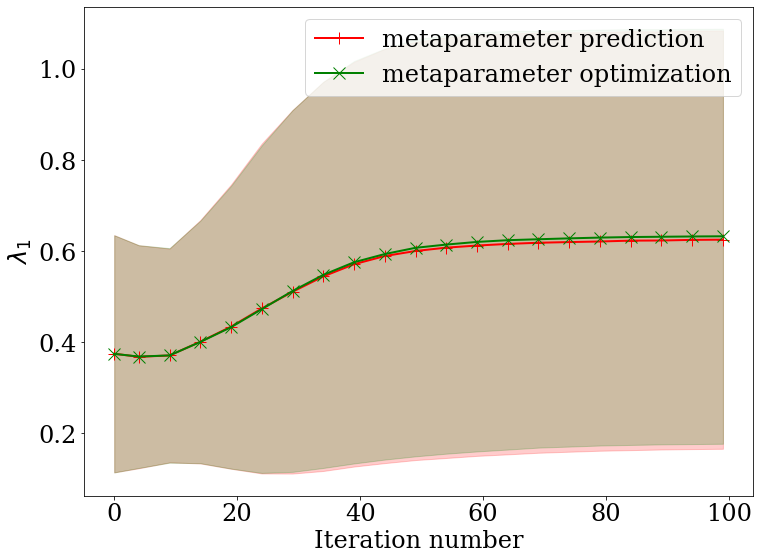

In [14]:
plot_data_params(data_s, 'lambda1', 'metaparameter prediction', 'red', '+')
plot_data_params(data_h, 'lambda1', 'metaparameter optimization', 'green', 'x')
plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_1$')
plt.legend()
plt.savefig('../figs/lambda1_iter'+experiment_version+'_eng_full.pdf')
plt.show()

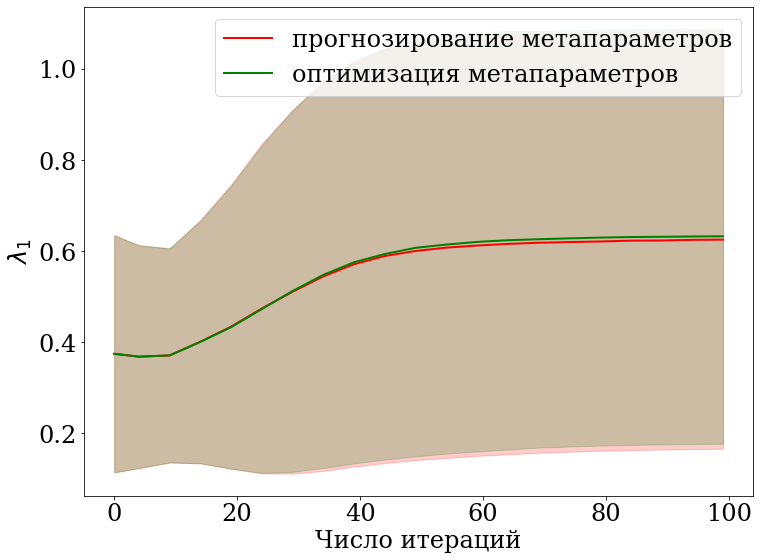

In [15]:
plot_data_params(data_s, 'lambda1', 'прогнозирование метапараметров', 'red', '')
plot_data_params(data_h, 'lambda1', 'оптимизация метапараметров', 'green', '')
plt.xlabel('Число итераций')
plt.ylabel(r'$\lambda_1$')

plt.legend()
plt.savefig('../figs/lambda1_iter'+experiment_version+'_color_full.pdf')
plt.show()

In [16]:
plot_data_params(data_s, 'lambda2', 'metaparameter prediction', 'red', '+')
plot_data_params(data_h, 'lambda2', 'metaparameter optimization', 'green', 'x')
plt.xlabel('Iteration number')
plt.ylabel(r'$\lambda_2$')
plt.legend()
plt.savefig('../figs/lambda2_iter'+experiment_version+'_eng_full.pdf')
plt.show()

KeyError: 'lambda2'

In [17]:
plot_data_params(data_s, 'lambda2', 'прогнозирование метапараметров', 'red', '')
plot_data_params(data_h, 'lambda2', 'оптимизация метапараметров', 'green', '')
plt.xlabel('Число итераций')
plt.ylabel(r'$\lambda_2$')
plt.legend()
plt.savefig('../figs/lambda2_iter'+experiment_version+'_color_full.pdf')
plt.show()

KeyError: 'lambda2'

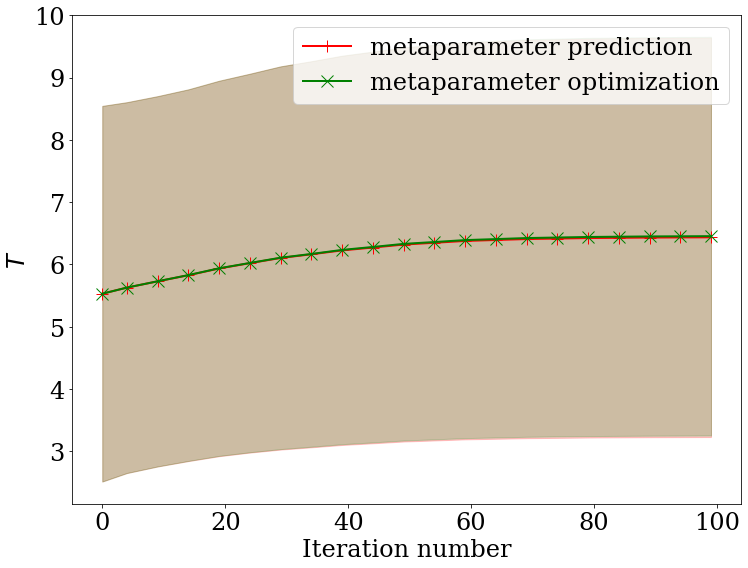

In [18]:
plot_data_params(data_s, 'temp', 'metaparameter prediction', 'red', '+')
plot_data_params(data_h, 'temp', 'metaparameter optimization', 'green', 'x')
plt.xlabel('Iteration number')
plt.ylabel(r'$T$')
plt.legend()
plt.savefig('../figs/temp_iter'+experiment_version+'_eng_full.pdf')
plt.show()

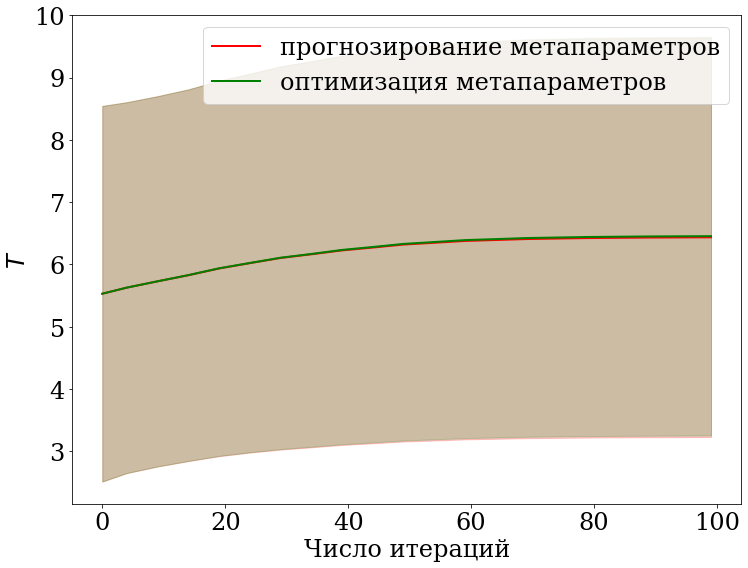

In [19]:
plot_data_params(data_s, 'temp', 'прогнозирование метапараметров', 'red', '')
plot_data_params(data_h, 'temp', 'оптимизация метапараметров', 'green', '')
plt.xlabel('Число итераций')
plt.ylabel(r'$T$')
plt.legend()
plt.savefig('../figs/temp_iter'+experiment_version+'_color_full.pdf')
plt.show()

In [31]:
import importlib
import funcs
importlib.reload(funcs)
funcs.cifar_base('test', 1, epoch_num, 0.99, 0.1, 'test', 
           tr_load=train_loader_no_augumentation, t_load=test_loader, 
           validate_every_epoch=validate_every_epoch, mode='distil', lr0=1.0, logits='../code/logits_resnet.npy')

current loss:2.2520804405212402:   6%|▌         | 5/90 [00:00<00:02, 41.61it/s]

{'epoch': 0, 'test loss': 2.2495217323303223, 'accuracy': 0.20029999315738678}


current loss:2.0656399726867676:  48%|████▊     | 43/90 [00:01<00:01, 39.69it/s]


KeyboardInterrupt: 